In [1]:
import pandas as pd
import plotly.graph_objects as go
from plotly_resampler import FigureResampler, FigureWidgetResampler
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import os

NameError: name '__file__' is not defined

In [13]:
#THOMAS:
#/home/s193864/Industrial-IoT-For-Digitization-Of-Electronic-Assets-Course/Final Project/data/pump_station_data.parquet

dirname = os.getcwd()
filename = dirname + "/data/pump_station_data.parquet"
print(filename)

/home/smrobot/Industrial-IoT-For-Digitization-Of-Electronic-Assets-Course/Final Project/data/pump_station_data.parquet


In [3]:
pump_station_data = pd.read_parquet(filename)
pump_station_data.head(5)
pump_station_data = pump_station_data[(pump_station_data["pump1_rpm"] > 0) & (pump_station_data["pump4_rpm"] == 0)]

In [4]:
train = pump_station_data.loc["2023-01-27":"2023-01-30"]
test = pump_station_data.loc["2023-02-27":"2023-03-02"] 
x_train = train["pump1_rpm"].values.reshape(-1,1)
y_train = train["outflow"].values.reshape(-1,1)
x_test = test["pump1_rpm"].values.reshape(-1,1)
y_test = test["outflow"].values.reshape(-1,1)

In [4]:
#import numpy as np
#pump_station_data.loc["2023-01-27 00:00:00.000000+00:00"]
#pump_station_data_subset = pump_station_data.iloc[946899:946899+86400]
#pump_station_data_subset2 = pump_station_data.iloc[946899+86400:946899+2*86400]
#n=0.5

#x_train, x_test = train_test_split(pump_station_data_subset, test_size=n)
#y_train, y_test = train_test_split(pump_station_data_subset2, test_size=n)


In [5]:
import pandas as pd 
from sysidentpy.model_structure_selection import FROLS 
from sysidentpy.basis_function._basis_function import Polynomial 
from sysidentpy.metrics import root_relative_squared_error 
from sysidentpy.utils.display_results import results



basis_function = Polynomial(degree=1)

model = FROLS(
    order_selection=True,
    n_info_values=10,
    extended_least_squares=False,
    ylag=2,
    xlag=2,
    info_criteria="aic",
    estimator="least_squares",
    basis_function=basis_function,
)
model.fit(X=x_train, 
          y=y_train)




/home/smrobot/miniconda3/envs/module3_env/lib/python3.11/site-packages/sysidentpy/utils/deprecation.py:37: FutureWarning: Passing a string to define the estimator will rise an error in v0.4.0. 
 You'll have to use FROLS(estimator=LeastSquares()) instead. 
 The only change is that you'll have to define the estimator first instead of passing a string like 'least_squares'. 
 This change will make easier to implement new estimators and it'll improve code readability.
  warnings.warn(message, FutureWarning)
/home/smrobot/miniconda3/envs/module3_env/lib/python3.11/site-packages/sysidentpy/model_structure_selection/forward_regression_orthogonal_least_squares.py:569: UserWarning: n_info_values is greater than the maximum number of all regressors space considering the chosen y_lag, u_lag, and non_degree. We set as 5
  self.info_values = self.information_criterion(reg_matrix, y)


In [6]:
yhat = model.predict(X=x_test, 
                     y=y_test,
                     forecast_horizon=60)

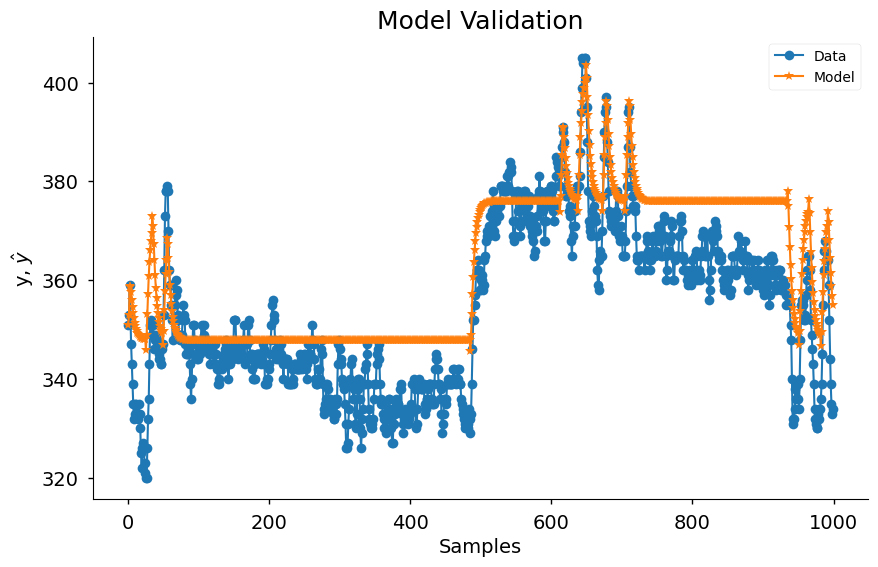

In [7]:
from sysidentpy.utils.plotting import plot_residues_correlation, plot_results

plot_results(y=y_test, yhat=yhat, n=1000, title="Model Validation",
    style='seaborn-v0_8-notebook',
    facecolor="white")

In [8]:

mask = y_test >= 0.9*x_test-680
filtered_x = x_test[mask]
filtered_y = y_test[mask]

y_fit = np.polyfit(filtered_x, filtered_y, 2)

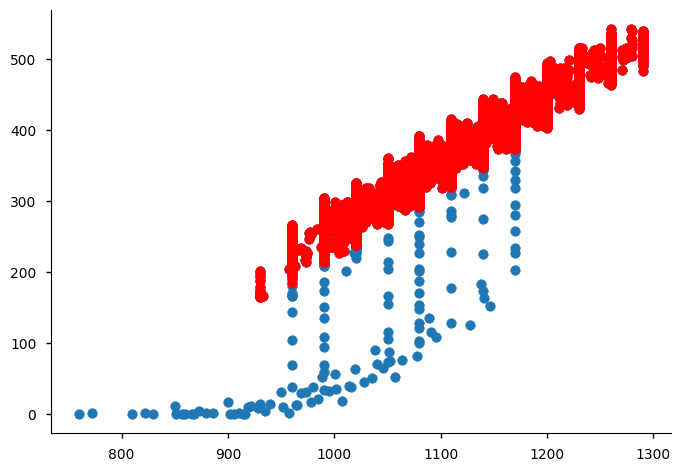

In [9]:
plt.scatter(y=y_test, x=x_test)
plt.scatter(y=filtered_y, x=filtered_x, color="red")
#plt.plot(y_fit, color="g")

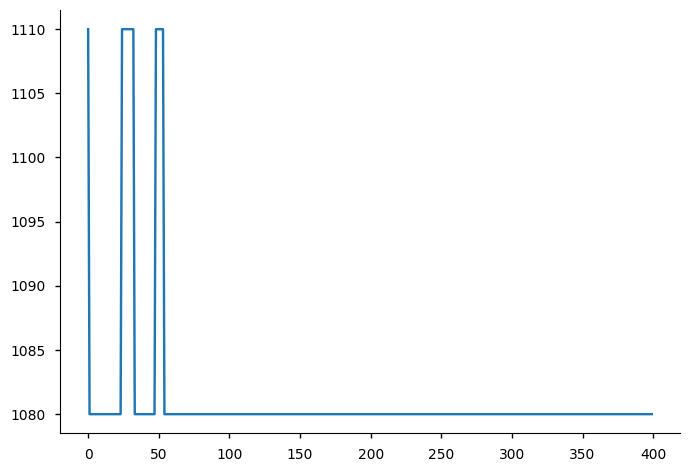

In [10]:
plt.plot(x_test.squeeze()[:400])

In [11]:


rrse = root_relative_squared_error(y_test, 
                                   yhat)
print(rrse)

r = pd.DataFrame(
    results(
        model.final_model,
        model.theta,
        model.err,
        model.n_terms,
        err_precision=8,
        dtype="sci",
    ),
    columns=["Regressors", "Parameters", "ERR"],
)
print(r)

0.2491088852320484
  Regressors   Parameters             ERR
0     y(k-1)   1.1736E+00  9.99824800E-01
1     y(k-2)  -2.9681E-01  1.10400394E-05
2    x1(k-2)   1.8670E-01  1.21761055E-06
3          1  -8.1871E+01  1.72776050E-05
4    x1(k-1)  -7.1214E-02  7.82510728E-07


In [12]:
fig = FigureWidgetResampler(go.Figure())
fig.add_trace(go.Scattergl(name='Pump 1 [rpm]', showlegend=True), hf_x=pump_station_data.index, hf_y=pump_station_data["pump1_rpm"])
fig.add_trace(go.Scattergl(name='Pump 4 [rpm]', showlegend=True), hf_x=pump_station_data.index, hf_y=pump_station_data["pump4_rpm"])
#fig.add_trace(go.Scattergl(name='Pump 1 [kW]', showlegend=True), hf_x=pump_station_data.index, hf_y=pump_station_data["pump1_power"])
#fig.add_trace(go.Scattergl(name='Pump 1 [kW]', showlegend=True), hf_x=pump_station_data.index, hf_y=pump_station_data["pump4_power"])
#fig.add_trace(go.Scattergl(name='Height', showlegend=True), hf_x=pump_station_data.index, hf_y=pump_station_data["height"])
#fig.add_trace(go.Scattergl(name='Outflow', showlegend=True), hf_x=pump_station_data.index, hf_y=pump_station_data["outflow"])

fig

fig.update_layout(
    autosize=False,
    width=1200,
    height=750,
    font_family="TimesNewRoman",
    legend=dict(
        title=None, orientation="h", y=-0.40, yanchor="bottom", x=0.5 , xanchor="center", font_color="white"
    ),
    plot_bgcolor='#333',
    paper_bgcolor="#333",
    title="This is graph",
    title_font_color="white",
    title_font_size=30
)

fig.update_xaxes(
    mirror=True,
    ticks='outside',
    showline=True,
    linecolor='gray',
    gridcolor='gray',
    color="white"
)
fig.update_yaxes(
    mirror=True,
    ticks='outside',
    showline=True,
    linecolor='gray',
    gridcolor='gray',
    color="white",
    ticksuffix="[rpm]", showgrid=True
)

ImportError: Please install ipywidgets>=7.0.0 to use the FigureWidget class

In [13]:
fig = FigureWidgetResampler(go.Figure())
#fig.add_trace(go.Scattergl(name='Pump 1 [rpm]', showlegend=True), hf_x=pump_station_data.index, hf_y=pump_station_data["pump1_rpm"])
#fig.add_trace(go.Scattergl(name='Pump 4 [rpm]', showlegend=True), hf_x=pump_station_data.index, hf_y=pump_station_data["pump4_rpm"])
fig.add_trace(go.Scattergl(name='Pump 1 [kW]', showlegend=True), hf_x=pump_station_data.index, hf_y=pump_station_data["pump1_power"])
fig.add_trace(go.Scattergl(name='Pump 1 [kW]', showlegend=True), hf_x=pump_station_data.index, hf_y=pump_station_data["pump4_power"])
#fig.add_trace(go.Scattergl(name='Height', showlegend=True), hf_x=pump_station_data.index, hf_y=pump_station_data["height"])
#fig.add_trace(go.Scattergl(name='Outflow', showlegend=True), hf_x=pump_station_data.index, hf_y=pump_station_data["outflow"])

fig

fig.update_layout(
    autosize=False,
    width=1200,
    height=750,
    font_family="TimesNewRoman",
    legend=dict(
        title=None, orientation="h", y=-0.40, yanchor="bottom", x=0.5 , xanchor="center", font_color="white"
    ),
    plot_bgcolor='#333',
    paper_bgcolor="#333",
    title="This is graph",
    title_font_color="white",
    title_font_size=30
)

fig.update_xaxes(
    mirror=True,
    ticks='outside',
    showline=True,
    linecolor='gray',
    gridcolor='gray',
    color="white"
)
fig.update_yaxes(
    mirror=True,
    ticks='outside',
    showline=True,
    linecolor='gray',
    gridcolor='gray',
    color="white",
    ticksuffix="[kW]", showgrid=True
)

FigureWidgetResampler({
    'data': [{'name': '<b style="color:sandybrown">[R]</b> Pump 1 [kW] <i style="color:#fc9944">~1h</i>',
              'showlegend': True,
              'type': 'scattergl',
              'uid': 'c68d5130-3bc0-40ff-a781-e2a8b2ee5aa9',
              'x': array([datetime.datetime(2023, 1, 16, 0, 0, 0, 970000, tzinfo=<UTC>),
                          datetime.datetime(2023, 1, 16, 0, 8, 42, 969000, tzinfo=<UTC>),
                          datetime.datetime(2023, 1, 16, 0, 44, 47, 969000, tzinfo=<UTC>), ...,
                          datetime.datetime(2023, 3, 1, 21, 16, 16, 342000, tzinfo=<UTC>),
                          datetime.datetime(2023, 3, 1, 22, 9, 47, 342000, tzinfo=<UTC>),
                          datetime.datetime(2023, 3, 1, 22, 32, 8, 343000, tzinfo=<UTC>)],
                         dtype=object),
              'y': array([57.54, 65.3 , 67.15, ..., 37.02, 35.28, 48.35])},
             {'name': '<b style="color:sandybrown">[R]</b> Pump 1 [kW] <i sty

In [14]:
fig = FigureWidgetResampler(make_subplots(rows=4, cols=1, shared_xaxes=True))

#fig.add_trace(go.Scattergl(name='Pump 1 [kW]', showlegend=True), hf_x=pump_station_data.index, hf_y=pump_station_data["pump1_power"])

fig.add_trace(go.Scattergl(name='Pump 1 [rpm]', showlegend=True),
        hf_x=pump_station_data_subset.index, 
        hf_y=pump_station_data_subset["pump1_rpm"], 
        row=1, 
        col=1
        )
fig.add_trace(go.Scattergl(name='Pump 4 [rpm]', showlegend=True),
        hf_x=pump_station_data_subset.index, 
        hf_y=pump_station_data_subset["pump4_rpm"], 
        row=1, 
        col=1)

fig.add_trace(go.Scattergl(name='Pump 1 [kW]', showlegend=True),
        hf_x=pump_station_data_subset.index, 
        hf_y=pump_station_data_subset["pump1_power"], 
        row=2, 
        col=1
        )
fig.add_trace(go.Scattergl(name='Pump 4 [kW]', showlegend=True),
        hf_x=pump_station_data_subset.index, 
        hf_y=pump_station_data_subset["pump4_power"], 
        row=2, 
        col=1)
fig.add_trace(go.Scattergl(name='Height', showlegend=True),
        hf_x=pump_station_data_subset.index, 
        hf_y=pump_station_data_subset["height"], 
        row=3, 
        col=1
        )

fig.add_trace(go.Scattergl(name='Outflow', showlegend=True),
        hf_x=pump_station_data_subset.index, 
        hf_y=pump_station_data_subset["outflow"], 
        row=4, 
        col=1)

fig.update_layout(height=1200, width=1200, title_text="Stacked Subplots")
fig.show()

NameError: name 'pump_station_data_subset' is not defined